# Particle tracking in *Mater* mutant mouse eggs during exocytosis

## Using this notebook

Contact: Ryan Dale, ryan.dale@nih.gov

This Jupyter notebook can be used to reproduce the particle tracking analysis in
in Vogt et al (2019) "Anchoring mouse cortical granules in the egg cortex ensures
timely trafficking to the plasma membrane for post-fertilization exocytosis",
Nature Communications.


For more information on using Jupyter notebooks, see the [documentation](https://jupyter-notebook.readthedocs.io/en/stable/).

We use [`conda`](https://conda.io/docs/) to manage the requirements in a reproducible fashion. If you already have the Anaconda Python distribution, you already have `conda`. Otherwise, please install [Miniconda](https://conda.io/miniconda.html), which is a minimal installation.

Once `conda` is installed, run the following from a terminal:

```bash
conda create -n particle-tracking --file requirements.txt
```

This will create an environment with all software required to run this notebook. Then you can activate the environment with:

```
source activate particle-tracking
```

and then start the notebook with 

```
jupyter notebook manuscript-figures.ipynb
```


*This notebook was run on Linux using the full `conda` environment specified in `full_environment.yaml`. That file lists the exact version of all packages installed at the time the figures were generated, and serves as a more archival record of the packages. It is likely that this notebook will run on MacOS and Windows, but this is untested. Success relies on availability of packages on those platforms.*

## Library imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import chisquare
from IPython.display import display, Markdown

The module `particle_tracking_lib.py` contains custom functions for working with particle tracking data such as adding deltas, computing regressions, plotting tracks, and more. We will be making heavy use of that module.

In [2]:
import particle_tracking_lib as lib

The `particle_tracking_lib` module is designed to be generally useful for different experimental designs. It is configured by:

- a TSV sample table that points to data files
- an optional TSV of metadata that can be used to attach additional information about tracks
- a list of columns that uniquely identifies a track across all data files



The first few lines of the sample table we're using:

In [3]:
pd.read_table('sampletable.tsv').head()

,condition,run,cell,filename
0,het,60917,10,data/CG_tracking_Het/060917/Spots_in_tracks_st...
1,het,60917,5,data/CG_tracking_Het/060917/Spots_in_tracks_st...
2,het,60917,6,data/CG_tracking_Het/060917/Spots_in_tracks_st...
3,het,60917,8,data/CG_tracking_Het/060917/Spots_in_tracks_st...
4,het,60917,2,data/CG_tracking_Het/060917/Spots_in_tracks_st...


And the first few lines of one of the data files:

In [4]:
 pd.read_csv('data/CG_tracking_Het/060917/Spots_in_tracks_statistics_timelapse10_060917.csv.gz', sep=',').head()

,,Label,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,...,MANUAL_COLOR,MEAN_INTENSITY,MEDIAN_INTENSITY,MIN_INTENSITY,MAX_INTENSITY,TOTAL_INTENSITY,STANDARD_DEVIATION,ESTIMATED_DIAMETER,CONTRAST,SNR
0,1,ID20758,20758,0,2.319,824.531,317.549,0,0,0,...,-10921639,23.186,21.686,-10.603,77.659,2990.946,16.790,8.498,0.679,1.117
1,2,ID20969,20969,0,2.415,823.378,318.172,0,1,1,...,-10921639,25.969,24.578,-15.021,72.544,3350.031,16.524,10.692,0.722,1.318
2,3,ID20267,20267,0,2.246,821.532,318.382,0,2,2,...,-10921639,24.375,22.835,-14.008,74.092,3144.427,18.305,9.955,0.679,1.077
3,4,ID20435,20435,0,2.352,822.622,317.598,0,3,3,...,-10921639,24.497,23.908,-17.290,77.002,3160.126,17.098,8.556,0.713,1.193
4,5,ID20551,20551,0,2.151,822.784,317.139,0,4,4,...,-10921639,23.307,23.202,-14.281,62.621,3006.557,16.143,10.802,0.719,1.208


## Data import

We will be loading all data files in and concatentating them into a large dataframe. For each loaded file, the corresponding metadata from `sampletable.tsv` will be attached (in the example above, we will have column for condition, run and cell).

For this experiment, a particular TRACK_ID (like `103`) can be present in multiple files. To uniquely identify a track for this experiment, we need to specify its condition, run, cell, and TRACK_ID. By providing these to the utility functions, we will get an additional `uid` column which is a `_`-separated string comprised of the values from those columns.

In [5]:
uid_columns = ['condition', 'run', 'cell', 'TRACK_ID']

In [6]:
df = lib.load_data_from_sampletable(
    'sampletable.tsv',
    comment='#',
    dtype={'run': str, 'cell': str, 'condition': str},
    uid_columns=uid_columns
)

Note the extra columns attached:

In [7]:
print("(rows, columns) of dataframe:", df.shape)
df.head()

(rows, columns) of dataframe: (85376, 26)


,,Label,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,...,MAX_INTENSITY,TOTAL_INTENSITY,STANDARD_DEVIATION,ESTIMATED_DIAMETER,CONTRAST,SNR,condition,run,cell,uid
0,1,ID20758,20758,0,2.319,824.531,317.549,0,0,0,...,77.659,2990.946,16.790,8.498,0.679,1.117,het,060917,10,het_060917_10_0
1,2,ID20969,20969,0,2.415,823.378,318.172,0,1,1,...,72.544,3350.031,16.524,10.692,0.722,1.318,het,060917,10,het_060917_10_0
2,3,ID20267,20267,0,2.246,821.532,318.382,0,2,2,...,74.092,3144.427,18.305,9.955,0.679,1.077,het,060917,10,het_060917_10_0
3,4,ID20435,20435,0,2.352,822.622,317.598,0,3,3,...,77.002,3160.126,17.098,8.556,0.713,1.193,het,060917,10,het_060917_10_0
4,5,ID20551,20551,0,2.151,822.784,317.139,0,4,4,...,62.621,3006.557,16.143,10.802,0.719,1.208,het,060917,10,het_060917_10_0


In particular, note the `uid` column, which is used to uniquely identify a track.

## Calculating derived values and attaching to dataframes

Next, we run the `attach_deltas` function. This function attaches various calculated values **for each timepoint**, calculated in a per-uid manner. Calculated values include percent of max intensity; dx, dy, dz; displacement; and more. See the help for `lib.attach_deltas` and `lib.deltas` for details.

In [8]:
df = lib.attach_deltas(df)

Next, we attach values that are calculated **for each uid level**, that is, per unique track. This includes the major and minor axes and angle of estimated ellipses encompassing the track; slope, intercept, R and p-value for a linear regression on percent-of-max intensity; total displacement; duration; and more. Note that we have to provide the `uid_columns` so the function knows how to group data points by unique tracks. Again, see the help for `lib.attach_per_track` for details.

This function returns two `pandas.DataFrame` objects: `df_full`, which contains all per-timepoint data for all tracks, and `by_uid`, which contains per-track data for all tracks.

In [9]:
df_full, by_uid = lib.attach_per_track(df, uid_columns)

In [10]:
df_full.head()

,,Label,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,...,slope,start,std_err,total_abs_disp,total_disp,v0,v1,rsquared,avg_abs_disp,avg_disp
0,1,ID38976,38976,0,4.350,1575.397,355.999,0,0,0,...,0.05911,0.0,0.005191,21.629225,21.629225,1.069248,6.550775,0.807056,0.655431,0.655431
1,2,ID39014,39014,0,4.284,1575.432,356.239,0,1,1,...,0.05911,0.0,0.005191,21.629225,21.629225,1.069248,6.550775,0.807056,0.655431,0.655431
2,3,ID39008,39008,0,4.397,1575.709,356.057,0,2,2,...,0.05911,0.0,0.005191,21.629225,21.629225,1.069248,6.550775,0.807056,0.655431,0.655431
3,4,ID38982,38982,0,4.392,1575.447,356.236,0,3,3,...,0.05911,0.0,0.005191,21.629225,21.629225,1.069248,6.550775,0.807056,0.655431,0.655431
4,5,ID38841,38841,0,4.407,1574.798,356.006,0,4,4,...,0.05911,0.0,0.005191,21.629225,21.629225,1.069248,6.550775,0.807056,0.655431,0.655431


In [11]:
by_uid.head()

,angle,avg_normdisp,centerx,centery,duration,eccentricity,end,intercept,max_disp,max_normdisp,...,v0,v1,rsquared,avg_abs_disp,avg_disp,condition,run,cell,TRACK_ID,TRACK_ID
uid,,,,,,,,,,,,,,,,,,,,,
het_053117_10_0,-49.153159,2.970732,-2.163455,-1.877182,33.0,6.126525,32.0,1.059564,2.350995,5.806416,...,1.069248,6.550775,0.807056,0.655431,0.655431,het,053117,10,0,0
het_053117_10_1,135.278992,4.499652,-2.961180,-3.326700,50.0,7.790273,49.0,0.954638,1.792960,7.223907,...,0.910069,7.089688,0.445151,0.603946,0.603946,het,053117,10,1,1
het_053117_10_10,146.335383,4.073936,-2.355649,-3.145973,37.0,4.293107,44.0,0.795962,1.298784,5.699748,...,1.327974,5.701133,0.368367,0.685023,0.685023,het,053117,10,10,10
het_053117_10_11,-51.273506,4.079140,-1.985600,-3.238575,40.0,1.339852,49.0,0.746431,1.927938,6.355336,...,3.777221,5.060918,0.294255,0.909551,0.909551,het,053117,10,11,11
het_053117_10_12,-55.186706,1.924711,-1.472500,-0.394700,10.0,4.219896,17.0,0.791684,1.817676,4.965011,...,1.227953,5.181834,0.004421,0.924447,0.924447,het,053117,10,12,12


Note that `by_uid` is keyed by UID.

## Classifying duration of tracks

Here we define short/medium/long based on visual cutoffs. In particular, the choice of 8 seconds as the cutoff between "short" and "medium" is based on the rapid falloff of the distribution around that time.

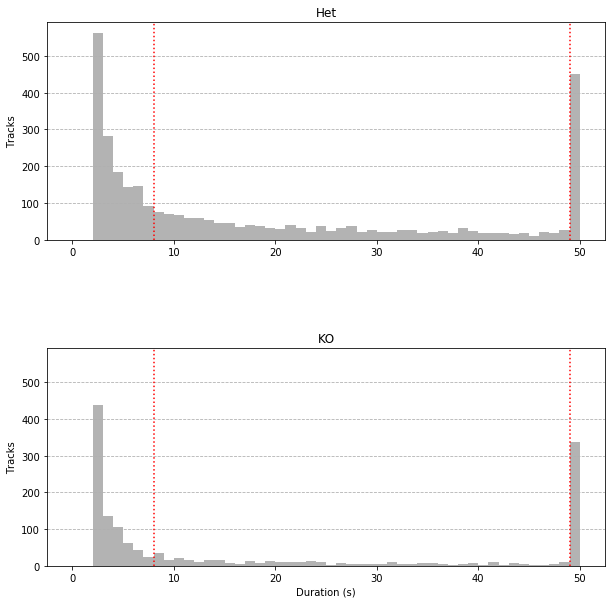

In [12]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax1, sharey=ax1)
kws = dict(bins=np.arange(51), normed=False, align='mid', color='0.7')
ax1.hist(by_uid.duration[by_uid.condition == 'het'], **kws);
ax2.hist(by_uid.duration[by_uid.condition == 'ko'], **kws);
ax2.set_xlabel('Duration (s)')
ax1.set_title('Het'); ax1.set_ylabel('Tracks');
ax2.set_title('KO'); ax2.set_ylabel('Tracks');
fig.subplots_adjust(hspace=0.5)
ax1.axvline(8, color='r', linestyle=':')
ax2.axvline(8, color='r', linestyle=':')
ax1.axvline(49, color='r', linestyle=':')
ax2.axvline(49, color='r', linestyle=':')
ax1.grid(axis='y', linestyle='--')
ax2.grid(axis='y', linestyle='--')
fig.savefig('duration_histograms.pdf', dpi=300)

We will add a new column to both the per-timepoint data in `df_full` as well as the aggregated track data in `by_uid` to indicate duration class:

In [13]:
by_uid.loc[by_uid.duration < 8, 'duration_class'] = 'short'
by_uid.loc[(by_uid.duration >= 8) & (by_uid.duration < 50), 'duration_class'] = 'medium'
by_uid.loc[by_uid.duration == 50, 'duration_class'] = 'long'
df_full.loc[df_full.duration < 8, 'duration_class'] = 'short'
df_full.loc[(df_full.duration >= 8) & (df_full.duration <50), 'duration_class'] = 'medium'
df_full.loc[df_full.duration == 50, 'duration_class'] = 'long'

To rule out possible time-specific artifacts in duration, such as photobleaching (which would result in short tracks clustered near time 0), we plot hexbin plots using the `particle_tracking_lib` module.

These plots show the number of tracks as color -- plotted as density rather than count since the total number of tracks differ between het and KO. The x-axis is duration, and the y-axis is start time in seconds.

We get a lower triangle because a later start time forces a shorter duration. The bins along the diagonal represent those tracks that started at some point during the 50-second observation time and continued to the end. The higher density of tracks in a vertical stripe near x=0 indicates many short-duration tracks, but these started at many different times. The higher density of bins along the x-axis near y=0 are those tracks that were present at the beginning of the observation period but stopped at some point. The center of the triangle, which is much lower density, contains tracks that both started and stopped within the 50-second observation window. 

Note that photobleaching would show up in this plot as a high density around (0, 0) -- this would indicate most short tracks started at time zero. Also note the very high density of tracks that were full 50-second duration. If we observed for longer time periods and re-plotted the data, we would expect a vertical smear of density at the mean duration of particles. Given the high density of 50-s tracks and the relative lack of tracks for which we catch the full duration (start and stop), we can infer that the actual lifetime of a particle in these experiments is substantially longer than 50 seconds.



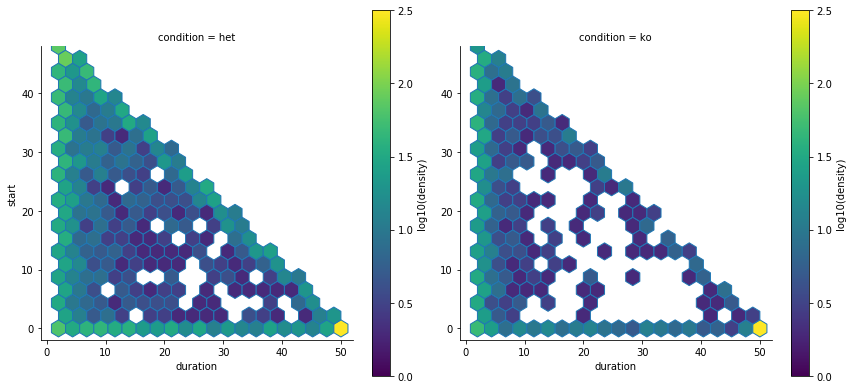

In [14]:
kws = dict(scatterkws=dict(mincnt=1, bins='log', gridsize=20, vmin=0, vmax=2.5), size=6, data=by_uid, sharex=False, sharey=False)
lib.pointplotter('duration', 'start', col='condition', **kws);
for ax in plt.gcf().axes:
    # differentiate between colorbar and not
    lims = ax.axis()
    if lims == (0.0, 1.0, 0.0, 1.0):
        continue
    ax.axis('square')
    ax.axis(ymin=-2, xmax=52, xmin=-1)
plt.gcf().savefig('hexbin_plots.pdf', dpi=300)

In [15]:
c = by_uid.groupby(['condition'])['duration_class'].agg('value_counts')
d = c / c.groupby('condition').agg('sum')
d.name = 'total'
#d = d.reset_index()
display(pd.DataFrame(d))

total
condition duration_class          
het       short           0.444724
          medium          0.428661
          long            0.126614
ko        short           0.535407
          medium          0.249504
          long            0.215089

In [16]:
sns.set_palette('deep')

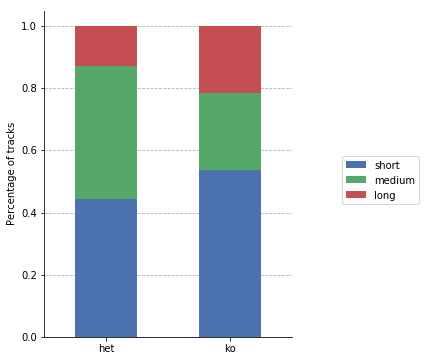

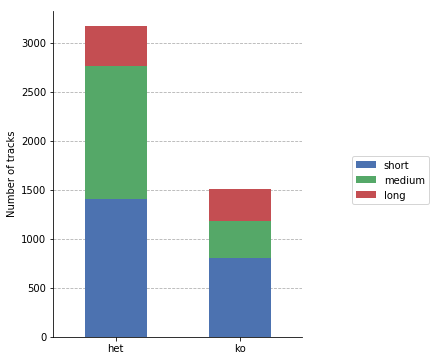

In [17]:
figsize = (6, 6)

c = by_uid.groupby(['condition'])['duration_class'].agg('value_counts')
d = c / c.groupby('condition').agg('sum')
d.name = 'total'
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ind = np.arange(2)
width = 0.5
last = None

for cls in ['short', 'medium', 'long']:
    y = d[:, cls]
    if last is not None:
        bottom = last
    else:
        bottom = np.zeros_like(y.values)
    ax.bar(ind, y, width, bottom, label=cls)
    last = bottom + y
ax.set_ylabel('Percentage of tracks')
ax.set_xticks(ind)
ax.set_xticklabels(d.index.levels[0])
ax.axis(xmin=-.5, xmax=1.5)
ax.grid(axis='y', linestyle='--')
ax.set_axisbelow(True)
sns.despine()
fig.subplots_adjust(right=0.7)
fig.legend(loc='center right')
fig.savefig('track_duration_percentages.pdf', dpi=300)


fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ind = np.arange(2)
last = None
for cls in ['short', 'medium', 'long']:
    y = c[:, cls]
    if last is not None:
        bottom = last
    else:
        bottom = np.zeros_like(y.values)
    ax.bar(ind, y, width, bottom, label=cls)
    last = bottom + y
ax.set_ylabel('Number of tracks')
ax.set_xticks(ind)
ax.set_xticklabels(d.index.levels[0])
ax.axis(xmin=-.5, xmax=1.5)
ax.grid(axis='y', linestyle='--')
ax.set_axisbelow(True)
sns.despine()
fig.subplots_adjust(right=0.7)
fig.legend(loc='center right');
fig.savefig('track_duration_counts.pdf', dpi=300);

In [18]:
chisquare(c['ko'], f_exp=c['het']).pvalue

2.4773470325227453e-214

The fraction of track durations is very significantly different between het and KO (chi-squared, p<2.2e-16), and this looks to be at the expense of medium-duration tracks.

## Classifying appearing/vanishing tracks

Similarly, we will select cutoffs for "appearing" and "vanishing", classified by the regression of the percent-of-max over time. Later we will only look at those tracks that had full 50-second duration, so in these histograms we only look at the long-duration tracks for choosing thresholds.

Note that the slopes have units of "percent of max intensity lost per second".

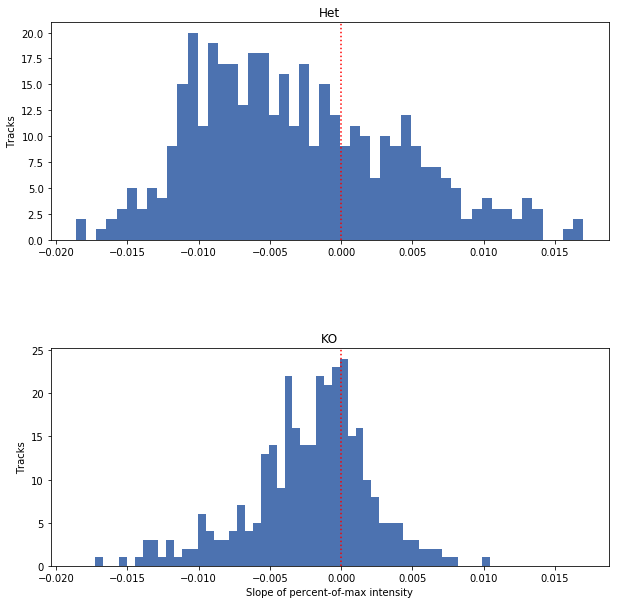

In [19]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax1)
kws = dict(bins=50)
ax1.hist(by_uid.slope[(by_uid.condition == 'het') & (by_uid.duration_class == 'long')], **kws);
ax2.hist(by_uid.slope[(by_uid.condition == 'ko') & (by_uid.duration_class == 'long')], **kws);
ax2.set_xlabel('Slope of percent-of-max intensity')
ax1.set_title('Het'); ax1.set_ylabel('Tracks');
ax2.set_title('KO'); ax2.set_ylabel('Tracks');
fig.subplots_adjust(hspace=0.5)
ax1.axvline(0, color='r', linestyle=':')
ax2.axvline(0, color='r', linestyle=':');

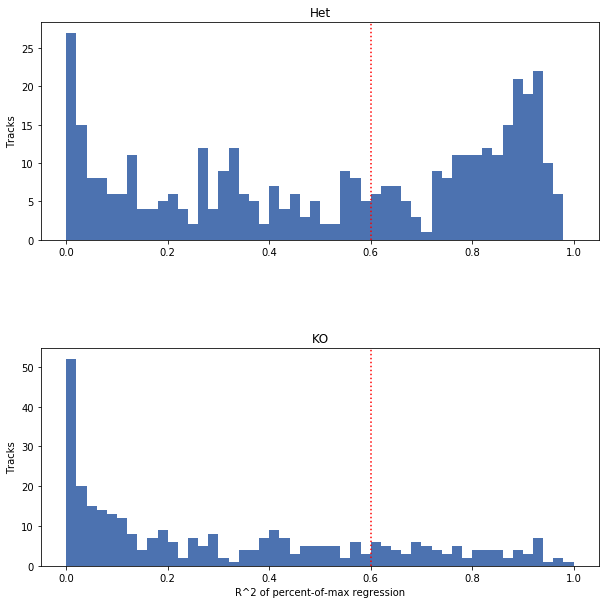

In [20]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax1)
kws = dict(bins=50, range=(0, 1))
ax1.hist(by_uid.rsquared[(by_uid.condition == 'het') & (by_uid.duration_class == 'long')], **kws);
ax2.hist(by_uid.rsquared[(by_uid.condition == 'ko') & (by_uid.duration_class == 'long')], **kws);
ax2.set_xlabel('R^2 of percent-of-max regression')
ax1.set_title('Het'); ax1.set_ylabel('Tracks');
ax2.set_title('KO'); ax2.set_ylabel('Tracks');
fig.subplots_adjust(hspace=0.5)
ax1.axvline(.6, color='r', linestyle=':')
ax2.axvline(.6, color='r', linestyle=':');

Based on the plots above, we create a "sig" column indicating the class of the regression using the following definition:

- "appearing" = Slope > 0, p-value < 0.05, and $R^2$ > 0.6 
- "vanishing" = Slope < 0, pvalue < 0.05, and $R^2$ > 0.6
- "neither" = all other tracks

In [21]:
by_uid.loc[by_uid.slope > 0, 'sig'] = 'appearing'
by_uid.loc[by_uid.slope < 0, 'sig'] = 'vanishing'
by_uid.loc[by_uid.p_value > 0.05, 'sig'] = 'neither'
by_uid.loc[by_uid.rsquared < 0.6, 'sig'] = 'neither'
df_full.loc[df_full.slope > 0, 'sig'] = 'appearing'
df_full.loc[df_full.slope < 0, 'sig'] = 'vanishing'
df_full.loc[df_full.p_value > 0.05, 'sig'] = 'neither'
df_full.loc[df_full.rsquared < 0.6, 'sig'] = 'neither'

Does the distribution of track durations differ between het and KO?

count   percent
condition sig                       
het       neither      207  0.514925
          vanishing    160  0.398010
          appearing     35  0.087065
ko        neither      250  0.769231
          vanishing     70  0.215385
          appearing      5  0.015385

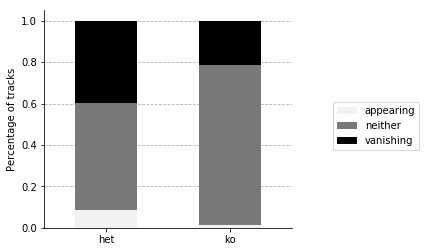

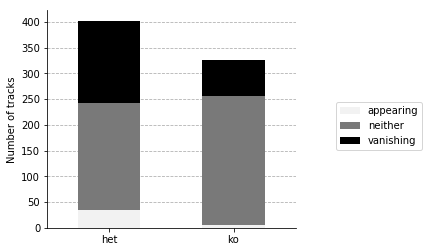

In [22]:
sns.set_palette(sns.light_palette('0.0', n_colors=3))

figsize = (6, 6)

c = by_uid[by_uid.duration == 50].groupby(['condition'])['sig'].agg('value_counts')
d = c / c.groupby('condition').agg('sum')
d.name = 'percent'
c.name = 'count'
display(pd.concat([c, d], axis=1))
fig = plt.figure()
ax = fig.add_subplot(111)
ind = np.arange(2)
width = 0.5
last = None
clss = ['appearing', 'neither', 'vanishing']
for cls in clss:
    y = d[:, cls]
    if last is not None:
        bottom = last
    else:
        bottom = np.zeros_like(y.values)
    ax.bar(ind, y, width, bottom, label=cls)
    last = bottom + y
ax.set_ylabel('Percentage of tracks')
ax.set_xticks(ind)
ax.set_xticklabels(d.index.levels[0])
ax.axis(xmin=-.5, xmax=1.5)
ax.grid(axis='y', linestyle='--')
ax.set_axisbelow(True)
sns.despine()
fig.subplots_adjust(right=0.7)
fig.legend(loc='center right')
fig.savefig('slope_class_percentages.pdf', dpi=300)


fig = plt.figure()
ax = fig.add_subplot(111)
ind = np.arange(2)
last = None
for cls in clss:
    y = c[:, cls]
    if last is not None:
        bottom = last
    else:
        bottom = np.zeros_like(y.values)
    ax.bar(ind, y, width, bottom, label=cls)
    last = bottom + y
ax.set_ylabel('Number of tracks')
ax.set_xticks(ind)
ax.set_xticklabels(d.index.levels[0])
ax.axis(xmin=-.5, xmax=1.5)
ax.grid(axis='y', linestyle='--')
ax.set_axisbelow(True)
sns.despine()
fig.subplots_adjust(right=0.7)
fig.legend(loc='center right');
fig.savefig('slope_class_counts.pdf', dpi=300);

In [23]:
chisquare(c['ko'], f_exp=c['het']).pvalue

3.0443588931255123e-19

The proportions of tracks with appearing/vanishing/neither slopes are significantly different in KO compared to het (chi-squared test, p=3.0e-19). These appear to be due to a decrease of both vanishing as well as appearing tracks, that is, the KO appears to have more tracks that maintain a more stable intensity over time.

## Average intensity over time

Recall that the `MEAN_INTENSITY` column indicates the mean intensity of the particle (total intensity divided by particle size) at each timepoint. For a big-picture view across genotypes, here we average that mean intensity per time over all timepoints for a track to get mean mean intensity over time for the track:

In [24]:
sns.set_palette('deep')
cols = list(by_uid.columns)
cols[30] =  'trackid'
by_uid.columns = cols
m = df_full.groupby('uid')['MEAN_INTENSITY'].apply(lambda x: x.mean())
by_uid['mean_intensity_over_time'] = m

Next, we create a factor plot from the seaborn package to compare these averaged intensities across duration classes and genotypes:

/home/dalerr/miniconda3/envs/pt/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


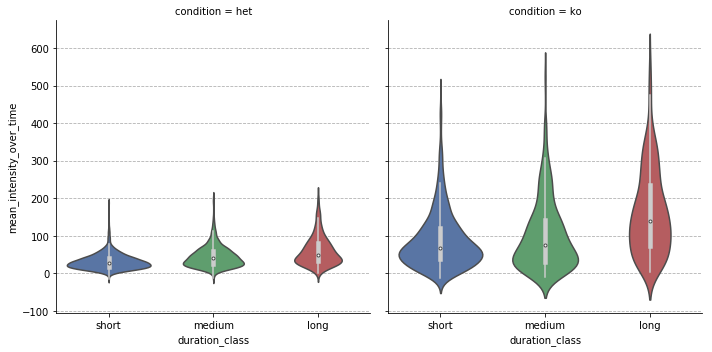

In [25]:
g = sns.factorplot(x='duration_class', y='mean_intensity_over_time', col='condition', data=by_uid, kind='violin', size=5,
               order=['short', 'medium', 'long']);
for ax in g.axes.ravel():
    ax.set_axisbelow(True)
    ax.grid(axis='y', linestyle='--')
    for c in ax.lines:
        c.set_color('0.8')

plt.gcf().savefig('intensity_by_duration_class.pdf', dpi=300)

Since the above plots perform lots of aggregation, it's important to look at the original data (intensity over time) in a more expanded plot. This corroborates the summarized violin plots above, which show that the intensity is substantially higher in KO than Het.

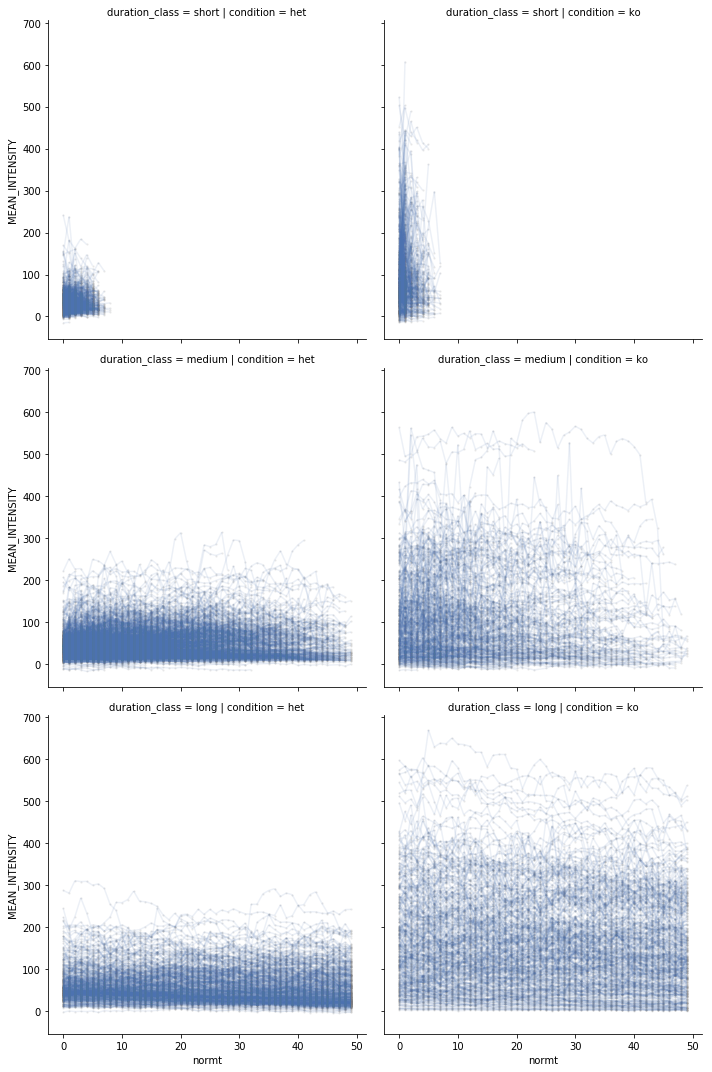

In [26]:
lib.facetplotter('normt', 'MEAN_INTENSITY', df_full, col='condition', row='duration_class',
                 row_order=['short', 'medium', 'long'],
                 dropna=False, size=5, collkws=dict(alpha=0.1, rasterized=True), scatterkws=dict(alpha=0.1, rasterized=True))

# For manuscript preparation, we save as both PNG and PDF so we can create hybrid
# vector/PDF plots (`rasterized=True` does not help in this case because we are 
# still creating thousands of separate lines, and they are exported as thousands
# of individual rasterized plots).
fig = plt.gcf()
for ax in fig.axes:
    sns.despine(ax=ax, top=True, bottom=True, left=True, right=True)
    for i in (ax.xaxis, ax.yaxis, ax.title):
        i.set_visible(False)
fig.savefig('mean_intensity-over-time.png', dpi=300)

for ax in fig.axes:
    sns.despine(ax=ax)
    for i in (ax.xaxis, ax.yaxis, ax.title):
        i.set_visible(True)    
    for coll in ax.collections:
        coll.set_visible(False)
#fig.savefig('mean_intensity-over-time.pdf', dpi=300);

# make everything visible for displaying in notebook
for ax in fig.axes:
    for coll in ax.collections:
        coll.set_visible(True)

Similarly, let's look at the "appearing" and "vanishing" tracks to verify that our classification worked as we thought:

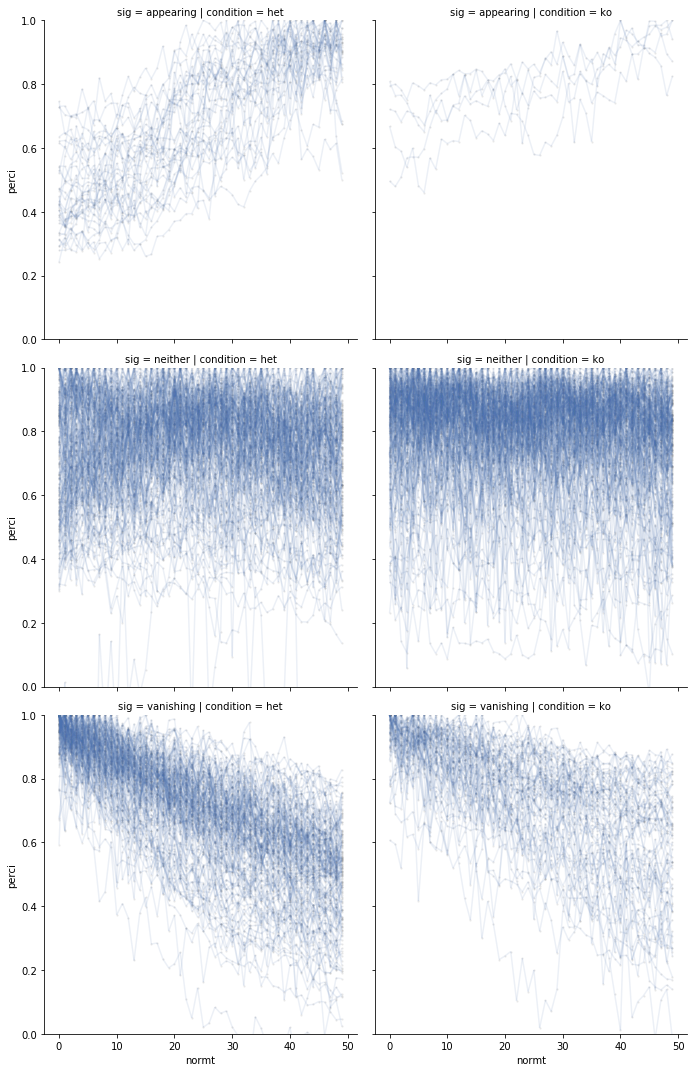

In [27]:
lib.facetplotter('normt', 'perci', df_full[df_full.duration==50], col='condition', row='sig',
                 row_order=['appearing', 'neither', 'vanishing'],                 
                 dropna=False, size=5, collkws=dict(alpha=0.1, rasterized=True),
                 scatterkws=dict(alpha=0.1, rasterized=True))
fig = plt.gcf()
for ax in fig.axes:
    ax.axis(ymin=0, ymax=1)
    
# PNG inside of plots and PDF axes for hybrid raster/vector
for ax in fig.axes:
    sns.despine(ax=ax, top=True, bottom=True, left=True, right=True)
    for i in (ax.xaxis, ax.yaxis, ax.title):
        i.set_visible(False) 
fig.savefig('perci-over-time.png', dpi=300)

for ax in fig.axes:
    sns.despine(ax=ax)
    for i in (ax.xaxis, ax.yaxis, ax.title):
        i.set_visible(True)    
    for coll in ax.collections:
        coll.set_visible(False)
#fig.savefig('perci-over-time.pdf', dpi=300)

for ax in fig.axes:
    for coll in ax.collections:
        coll.set_visible(True)

## Example tracks
Here we extract the relevant data and construct the plots for the example tracks shown in the manuscript:

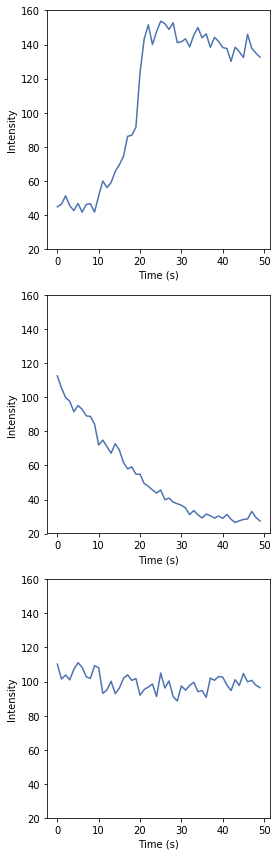

In [28]:
id1 = 'het_062017_3_29'
id2 = 'het_062017_5_8'
id3 = 'het_060917_6_21'

fig = plt.figure(figsize=(4,12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312, sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(313, sharex=ax1, sharey=ax1)

sub1 = df_full[df_full.uid == id1]
sub2 = df_full[df_full.uid == id2]
sub3 = df_full[df_full.uid == id3]

ax1.plot(sub1.POSITION_T, sub1.MEAN_INTENSITY)
ax2.plot(sub2.POSITION_T, sub2.MEAN_INTENSITY)
ax3.plot(sub3.POSITION_T, sub3.MEAN_INTENSITY)
for ax in fig.axes:
    ax.set_ylabel('Intensity')
    ax.set_xlabel('Time (s)')
fig.tight_layout()
fig.savefig('individual.png')
fig.savefig('individual.pdf')


Finally, some summaries of the total number of cells and tracks:

In [29]:
by_uid['uid'] = by_uid.index

In [30]:
print("Slope classes by genotype")
display(pd.DataFrame(by_uid.groupby('condition')['sig'].value_counts()))

print("Duration classes by genotype")
display(pd.DataFrame(by_uid.groupby('condition')['duration_class'].value_counts()))

print("Tracks by genotype")
display(pd.DataFrame(by_uid.groupby('condition')['uid'].agg('count')))

print("All slope classes")
display(pd.DataFrame(by_uid['sig'].value_counts()))

print("All duration classes")
display(pd.DataFrame(by_uid['duration_class'].value_counts()))

Slope classes by genotype


sig
condition sig            
het       neither    1911
          vanishing   719
          appearing   545
ko        neither     894
          vanishing   365
          appearing   252

Duration classes by genotype


duration_class
condition duration_class                
het       short                     1412
          medium                    1361
          long                       402
ko        short                      809
          medium                     377
          long                       325

Tracks by genotype


,uid
condition,
het,3175
ko,1511


All slope classes


,sig
neither,2805
vanishing,1084
appearing,797


All duration classes


,duration_class
short,2221
medium,1738
long,727


## Further inspection


Are vesicles with shorter tracks more likely to move more? To investigate this we use average absolute displacement as our metric, which is the average displacement a vesicle moved in one time step across its entire duration. Since all time steps are the same, this translates to movement speed.

/home/dalerr/miniconda3/envs/pt/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


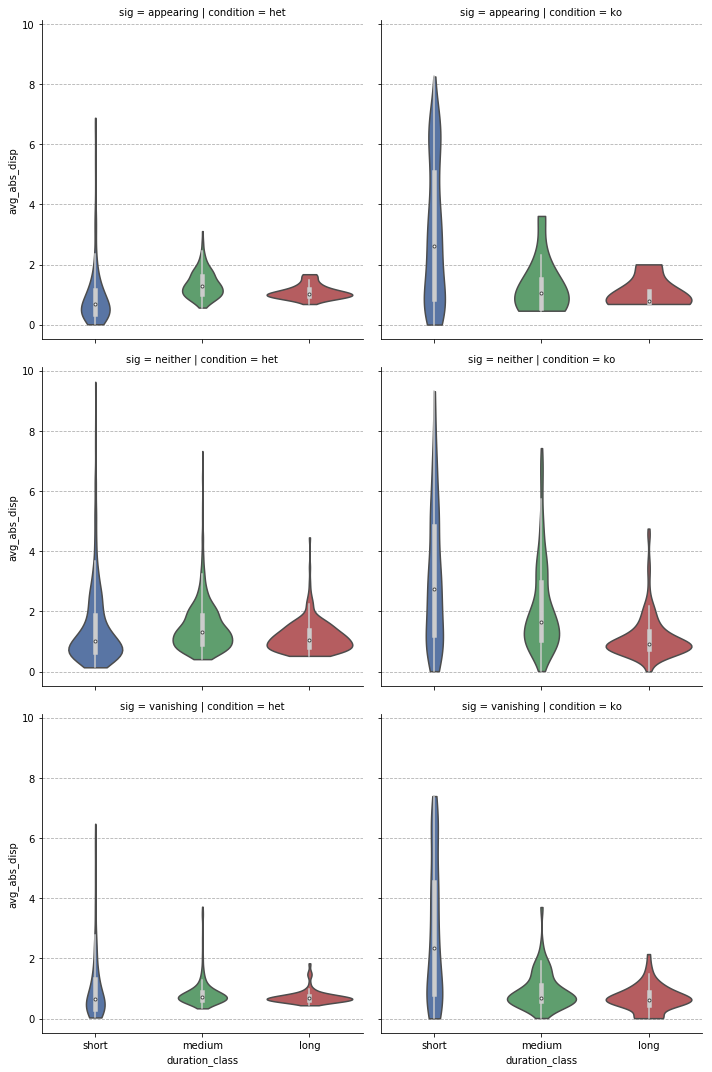

In [31]:
g = sns.factorplot(x='duration_class', y='avg_abs_disp', col='condition', row='sig', data=by_uid, kind='violin', size=5,
               order=['short', 'medium', 'long'], cut=0)
for ax in g.axes.ravel():
    ax.set_axisbelow(True)
    ax.grid(axis='y', linestyle='--')
    for c in ax.lines:
        c.set_color('0.8')

plt.gcf().savefig('avg_abs_disp_by_class.pdf', dpi=300)

Specifically, the short-duration tracks in KO have more variable displacements. They also appear to have higher average displacement; that is, shorter tracks move faster specifically in KO.

To quantify this, we do pairwise Mann-Whitney U tests with multiple testing correction.

In [32]:
ds = []
for cls in ['short', 'medium', 'long']:
    for sig in ['appearing', 'vanishing', 'neither']:
        x = by_uid.loc[
                (
                    (by_uid.condition == 'het')
                    & (by_uid.duration_class == cls)
                    & (by_uid.sig == sig)
                )
                , 'avg_abs_disp'
        ]
        
        y = by_uid.loc[
            (
                
                (by_uid.condition=='ko')
                & (by_uid.duration_class == cls)
                & (by_uid.sig == sig)
            )
            , 'avg_abs_disp'
        ]
        
        p = stats.mannwhitneyu(x, y)
            
        ds.append(dict(
            cls=cls, sig=sig, pval=p[1], med_het=np.median(x), med_ko=np.median(y), n_het=len(x), n_ko=len(y)))
        
ds = pd.DataFrame(ds)
from statsmodels.stats import multitest
s, f = multitest.fdrcorrection(ds.pval)
ds['fdr'] = f
ds['significant'] = s
ds['sign'] = 1
ds.loc[ds['med_ko'] < ds['med_het'], 'sign'] *= -1
ds.loc[~ds['significant'], 'sign'] = np.nan
ds['signed_phred_fdr'] = ds['sign'] * -np.log10(ds['fdr'])
ds

,cls,med_het,med_ko,n_het,n_ko,pval,sig,fdr,significant,sign,signed_phred_fdr
0,short,0.672345,2.623926,340,235,2.968923e-30,appearing,1.336015e-29,True,1.0,28.874189
1,short,0.643202,2.356183,324,240,3.334866e-23,vanishing,1.000460e-22,True,1.0,21.999800
2,short,1.007600,2.745413,748,334,6.478525e-37,neither,5.830672e-36,True,1.0,35.234281
3,medium,1.274491,1.067107,170,12,6.326264e-02,appearing,8.133768e-02,False,NaN,NaN
4,medium,0.718246,0.678643,235,55,3.705315e-01,vanishing,3.705315e-01,False,NaN,NaN
5,medium,1.323767,1.638015,956,310,6.760616e-10,neither,1.521139e-09,True,1.0,8.817831
6,long,1.029888,0.801234,35,5,1.532965e-01,appearing,1.724585e-01,False,NaN,NaN
7,long,0.669485,0.622899,160,70,5.538076e-02,vanishing,8.133768e-02,False,NaN,NaN
8,long,1.060103,0.929252,207,250,9.336041e-03,neither,1.680487e-02,True,-1.0,-1.774565


To visually represent the above table, we can turn it into a heatmap where rows are duration classes and columns are slope classes. For each row/column combination, darker red means KO is significantly faster than het. For the "long, neither" class, KO is slightly slower than het.

From this we can conclude that short-duration tracks move more quickly in KO than het, regardless of if they are appearing, vanishing, or neither. As tracks get longer, appearing and vanishing are no different, and "neither" tracks have a more complex pattern.

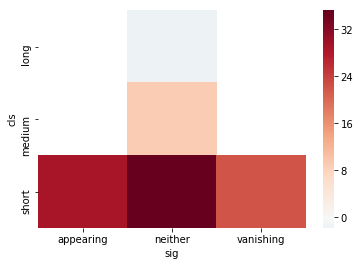

In [33]:
g = sns.heatmap(ds.pivot('cls', 'sig', 'signed_phred_fdr'), cmap='RdBu_r', center=0)
g.figure.savefig('mwu_fdr_heatmap.pdf')